# Problem 1 : Pandemic Zombies

**This is intended for educational purposes and is not intended as a realistic simulation of the COVID-19 virus.**

Suppose you have a pandemic of some disease. In this case, we will simulate the zombie apocalypse. As such, we will consider `n_walker` random walkers in 2 dimensions that each take `n_steps` steps. At each step, the walkers can move `dx` units. The walkers are confined to a single 1x1 room with cyclic boundary conditions in x and y (so, the walkers wrap around if they wander off the edge). There is a configurable initial number of infected individuals, `n_infected`.  

The code below assumes that there is zero rate of transmission from the infected individuals (i.e., passive zombies). The animation shows the paths of the walkers. The healthy individuals show up as blue dots. The zombies show up as red dots.  

- **Part a (15 points)**: Implement an "infection rate" `P_i` and an "infection distance" `d_i` where any walkers that are within the infection distance `d_i` to an infected individual have a probability `P_i` to be infected. They then infect others in later time steps. The animation should reflect the changes. (Hint: This can't be vectorized, so you have to use for loops). Assume: `n_walkers=100`, `n_steps=100`, `n_infected=4`, `dx=0.01`, `P_i = 0.1`, and `d_i=0.1`. 
- **Part b (10 points)**: Plot the number of total infections in the sample as a function of time step for `P_i = 0.1, 0.2, 0.3`, and for `d_i = 0.01, 0.02, 0.03`. Assume: `n_walkers=100`, `n_steps=1000`, `n_infected=4`, `dx=0.01`.

Remember to stay healthy and practice social distancing (keep outside of the rate `d_i` in real life)!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [2]:
# Make the plots a bit bigger to see
# NOTE: Must be done in a separate cell
plt.rcParams['figure.dpi'] = 100

### Run the walkers

In [3]:
class Zombies(object):
    def __init__(self, n_walkers, n_steps, n_infected, dx, P_i, d_i):
        self.dims = 2
        self.n_walkers = n_walkers
        self.n_steps = n_steps
        self.n_infected = n_infected
        self.t = np.arange(n_steps)
        # Walkers can go in + direction, - direction, or stay still
        self.dx = dx
        self.P_i = P_i
        self.d_i = d_i
        self.step_set = np.array([-1, 0, 1]) * self.dx
        # The shape is for "n_walkers" in "dims" dimensions taking "n_steps".
        # So, in 1d if there are 10 walkers making 100 steps each,
        # it will be (10, 2, 100)
        self.step_shape = (self.n_walkers,self.dims,self.n_steps)
        self.init_positions = np.random.uniform( 0.0, 1.0, size=(self.n_walkers, self.dims) )
        self.init_infected = np.zeros( self.n_walkers, dtype=int )
        self.init_infected[0:self.n_infected] = 1
        np.random.shuffle( self.init_infected )
        self.positions = None
        self.infected = np.zeros( shape=(self.n_walkers,self.n_steps), dtype=int)
        self.infected[:,:] = self.init_infected[:,np.newaxis]
        self.ii = np.arange(self.n_walkers)
        self.jj = np.arange(self.n_infected)
        self.tot_infected = []
        
    def walk(self):
        # These are the steps at each stage  
        self.steps = np.random.choice(a=self.step_set, size=self.step_shape)
        
        # Now we add up the steps for each walker to get the x positions
        self.positions = (self.init_positions[:,:,np.newaxis] + self.steps.cumsum(axis=2)) % 1.0

        ########################
        ### Part a: Here is where you will set the infections at each step. 
        ###         Currently this is the same as an infection rate of zero. 
        ########################
#         print(self.infected)
        infected_coor = np.argwhere(self.init_infected)
        for t in range(self.n_steps):
#             print(self.n_infected,self.infected[:,t])
            self.tot_infected.append(self.n_infected)
            pos = self.positions[:,:,t]
            for i in range(0,self.n_walkers):
                zombie_pos = np.squeeze(self.positions[infected_coor,:,t])
                for j in infected_coor:
                    dd = np.sqrt(( pos[i,0] - pos[j,0] )**2 + ( pos[i,1] - pos[j,1] )**2)
                    if dd < self.d_i and i != j: 
                        randummy = np.random.rand()
                        if randummy < self.P_i:
                            if self.n_infected != self.n_walkers:
                                self.n_infected += 1
                            infected_coor = np.unique(np.append(infected_coor,[[i]]))
                            self.infected[i,t:self.n_steps] = 1

#         print(self.infected)
        return                   
                      
        
        


### Draw the walkers

In [4]:
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

In [5]:
class AnimatedScatter(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    def __init__(self, n_walkers=100, n_steps=10, n_infected=4, dx=0.1, P_i = 0.04, d_i=0.1):
        self.stream = self.data_stream()
        self.zombies=Zombies(n_walkers=n_walkers,n_steps=n_steps,n_infected=n_infected,dx=dx,P_i=P_i,d_i=d_i)
        self.zombies.walk()
        # Setup the figure and axes...
        self.fig, self.ax = plt.subplots()
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=100, frames=n_steps,
                                           init_func=self.setup_plot, blit=False)

    def setup_plot(self):

        """Initial drawing of the scatter plot."""
        data = next(self.stream)
        self.scat = self.ax.scatter(data[0], data[1], animated=True, c=data[2],
                                   cmap='coolwarm')
        self.ax.axis([0, 1, 0, 1])

        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,
    

    def data_stream(self):
        i = 0
        while True:
            if i >= self.zombies.n_steps:
                i = 0
            x = self.zombies.positions[:,0,i]
            y = self.zombies.positions[:,1,i]
            c = self.zombies.infected[:,i]
            i += 1
            yield np.c_[x,y,c]

    def update(self, i):
        """Update the scatter plot."""    
        data = next(self.stream)
        
        # Set x and y data...
        self.scat.set_offsets(data[:,:2])
        self.scat.set_array(data[:,2])

        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,



<IPython.core.display.Javascript object>


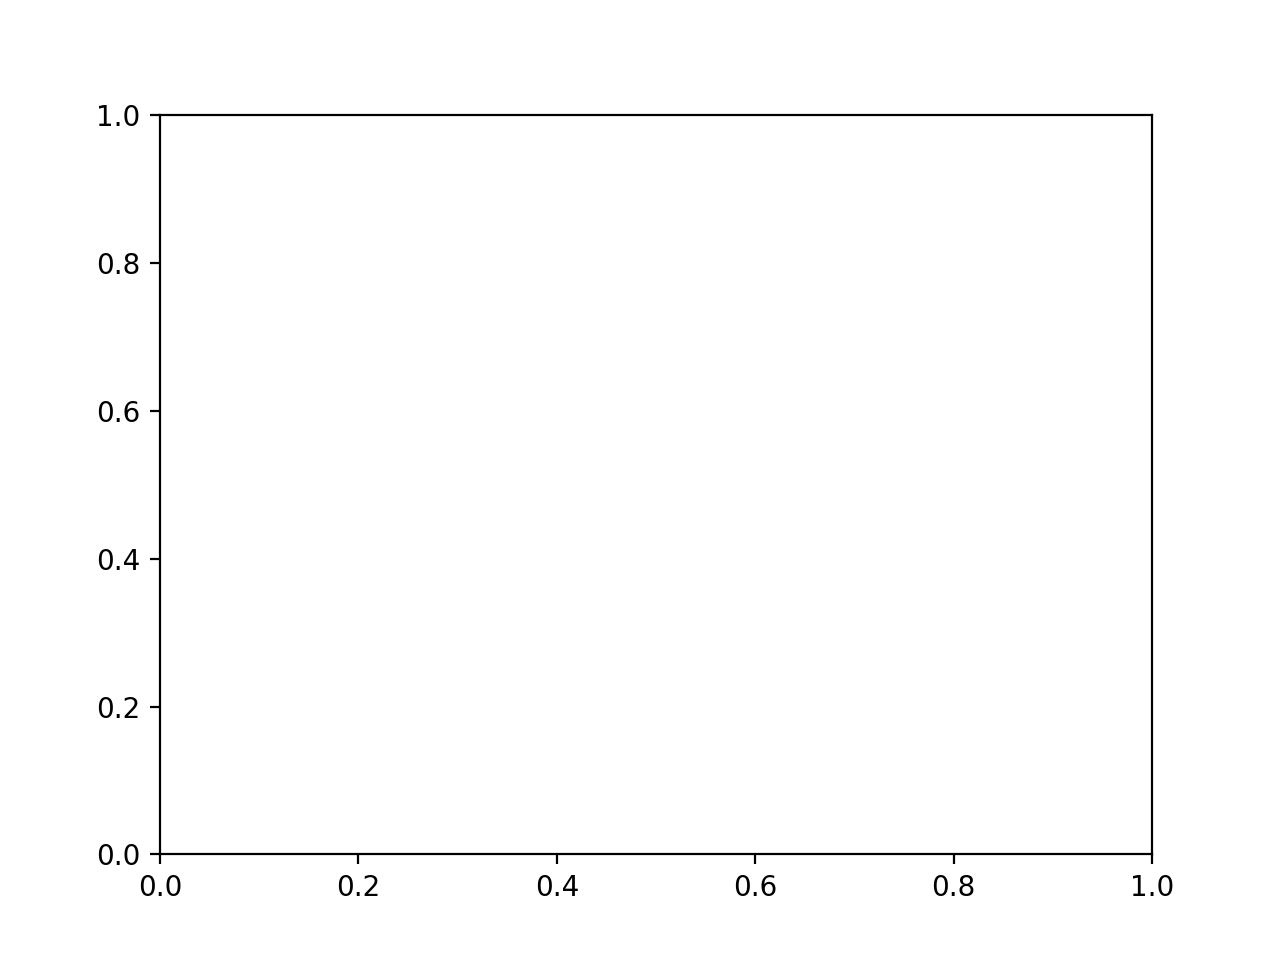

In [18]:
%matplotlib notebook
a = AnimatedScatter(n_walkers=100, n_steps=100, n_infected=4, dx=0.01, P_i = 0.1, d_i=0.1)
HTML(a.ani.to_html5_video())


### Part b should go here:   
First part considers $p_i = 0.1,0.2,0.3$ for a constant $d_i = 0.01,0.02,0.03$.

In [13]:
#### P_i = 0.1 , d_i = 0.1 
undead1 = Zombies(n_walkers=100, n_steps=1000, n_infected=4, dx=0.01, P_i = 0.1, d_i=0.1)
undead1.walk()

#### P_i = 0.2 , d_i = 0.1 
undead2 = Zombies(n_walkers=100, n_steps=1000, n_infected=4, dx=0.01, P_i = 0.2, d_i=0.1)
undead2.walk()

#### P_i = 0.3 , d_i = 0.1 
undead3 = Zombies(n_walkers=100, n_steps=1000, n_infected=4, dx=0.01, P_i = 0.3, d_i=0.1)
undead3.walk()




<IPython.core.display.Javascript object>


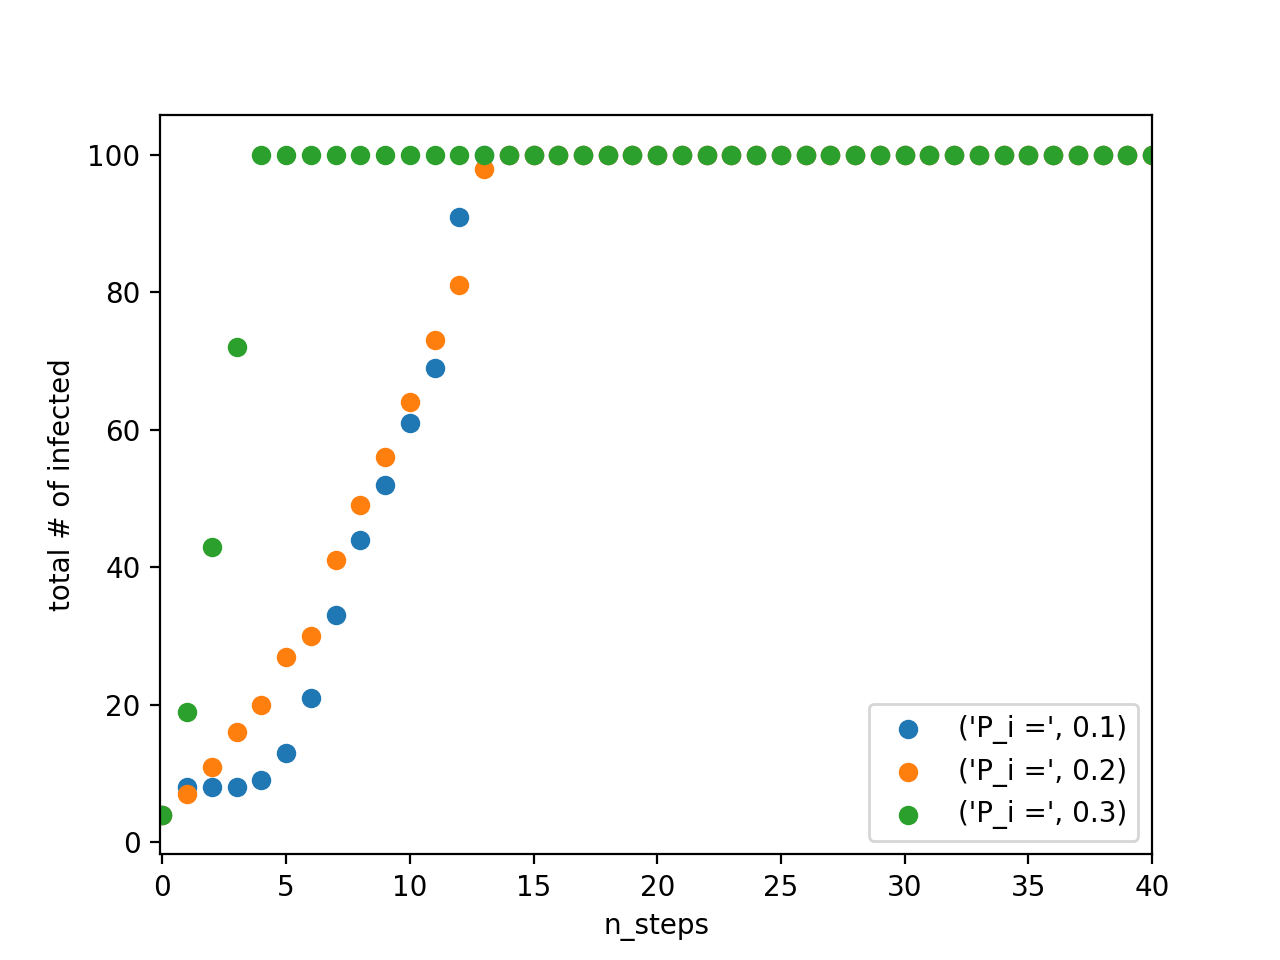

In [17]:
t = np.arange(0,undead1.n_steps,1)

plt.scatter(t,undead1.tot_infected, label = ('P_i =',undead1.P_i))
plt.scatter(t,undead2.tot_infected, label = ('P_i =',undead2.P_i))
plt.scatter(t,undead3.tot_infected, label = ('P_i =',undead3.P_i))

plt.legend()
plt.xlabel("n_steps")
plt.ylabel("total # of infected")
plt.xlim(-0.1,40)
# plt.savefig('p1_f1.pdf')
plt.show()

In [9]:
# #### P_i = 0.1 , d_i = 0.01
# undead1 = Zombies(n_walkers=100, n_steps=1000, n_infected=4, dx=0.01, P_i = 0.1, d_i=0.01)
# undead1.walk()

# #### P_i = 0.1 , d_i = 0.02
# undead2 = Zombies(n_walkers=100, n_steps=1000, n_infected=4, dx=0.01, P_i = 0.1, d_i=0.02)
# undead2.walk()

# #### P_i = 0.1 , d_i = 0.03 
# undead3 = Zombies(n_walkers=100, n_steps=1000, n_infected=4, dx=0.01, P_i = 0.1, d_i=0.03)
# undead3.walk()




In [10]:
# t = np.arange(0,undead1.n_steps,1)

# plt.plot(t,undead1.tot_infected,  label = ('d_i =',undead1.d_i))
# plt.plot(t,undead2.tot_infected,  label = ('d_i =',undead2.d_i))
# plt.plot(t,undead3.tot_infected,  label = ('d_i =',undead3.d_i))

# plt.legend()
# plt.xlabel("n_steps")
# plt.ylabel("total # of infected")
# plt.xlim(0,100)
# # plt.savefig('p1_f2.pdf')
# plt.show()